# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Baseline Models

The simplest models will be checked to act as a starting point that we will beat.

In [1]:
# imports

import os
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter

In [2]:
# More imports for our traditional machine learning

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

## NLP imports

In the next cell, we have more imports for our NLP related machine learning.  
If the gensim import gives you an error like "Cannot import name 'triu' from 'scipy.linalg' then please run in another cell:  
`!pip install "scipy<1.13"`  


In [3]:
# NLP related imports

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [4]:
# Finally, more imports for more advanced machine learning

from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

In [5]:
# Constants - used for printing to stdout in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [ ]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')


In [8]:
%matplotlib inline

# Loading the pkl files

Let's avoid curating all our data again! Load in the pickle files


In [9]:
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)



A rather pleasing Test Harness that will evaluate any model against 250 items from the Test set

And show us the results in a visually satisfying way.

You write a function of this form:

```
def my_prediction_function(item):
    # my code here
    return my_estimate
```

And then you call:

`Tester.test(my_prediction_function)`

To evaluate your model.

In [12]:
class Tester:

    def __init__(self, predictor, title=None, data=test, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"
    
    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function):
        cls(function).run()


Let's start with a random number generator!

In [13]:
def random_pricer(item):
    return random.randrange(1,1000)

1: Guess: $655.00 Truth: $195.99 Error: $459.01 SLE: 1.45 Item: Vertex Ultraphonix MKII Overdrive
2: Guess: $115.00 Truth: $38.99 Error: $76.01 SLE: 1.13 Item: Wood Grip | Universal Conversion Kit | B...
3: Guess: $26.00 Truth: $1.00 Error: $25.00 SLE: 6.77 Item: Traxxas 1726 Antenna, Tube, Vinyl Antenn...
4: Guess: $760.00 Truth: $299.99 Error: $460.01 SLE: 0.86 Item: Jackson JS Series Dinky Arch Top JS32Q D...
5: Guess: $282.00 Truth: $374.99 Error: $92.99 SLE: 0.08 Item: TOTO LPT754.8#01 Whitney Lavatory and Pe...
6: Guess: $251.00 Truth: $64.95 Error: $186.05 SLE: 1.80 Item: Sliding Glass Patio Door Handle Set, Mor...
7: Guess: $229.00 Truth: $279.99 Error: $50.99 SLE: 0.04 Item: First Watch / Homak 6-Gun Security Cabin...
8: Guess: $143.00 Truth: $131.85 Error: $11.15 SLE: 0.01 Item: WEN 3921 16-inch Two-Direction Variable ...
9: Guess: $755.00 Truth: $185.11 Error: $569.89 SLE: 1.96 Item: Tropwellhouse Crytal Ceiling Fan with Li...
10: Guess: $105.00 Truth: $72.69 Error: $32.31 S

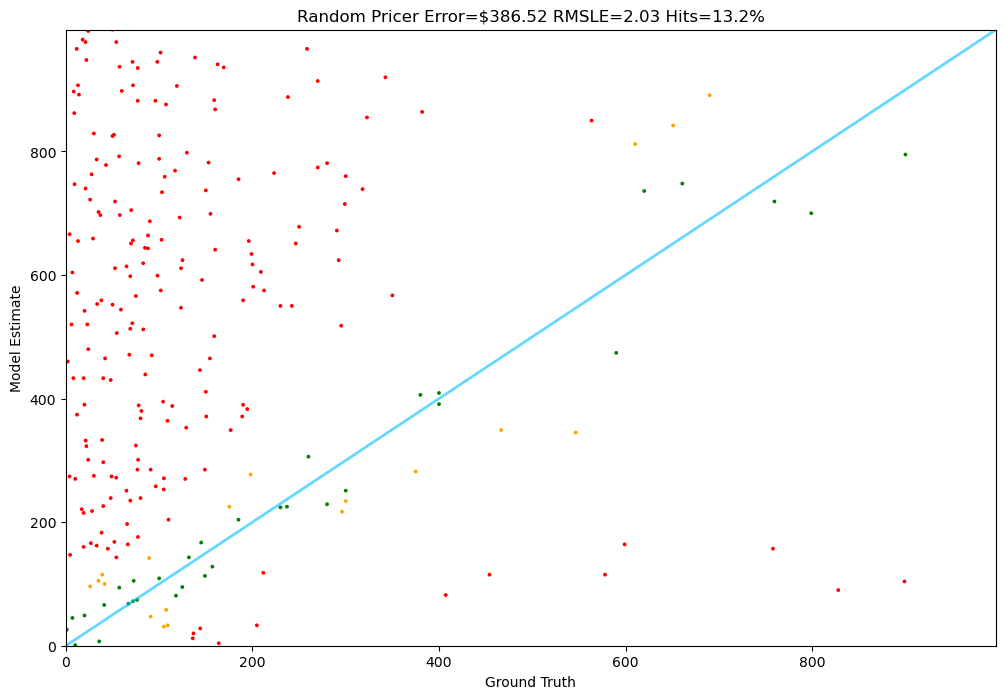

In [14]:
# Set the random seed

random.seed(42)

# Run our TestRunner
Tester.test(random_pricer)

In [15]:
# That was fun!
# We can do better - here's another rather trivial model

training_prices = [item.price for item in train]
training_average = sum(training_prices) / len(training_prices)

def constant_pricer(item):
    return training_average

1: Guess: $151.58 Truth: $195.99 Error: $44.41 SLE: 0.07 Item: Vertex Ultraphonix MKII Overdrive
2: Guess: $151.58 Truth: $38.99 Error: $112.59 SLE: 1.79 Item: Wood Grip | Universal Conversion Kit | B...
3: Guess: $151.58 Truth: $1.00 Error: $150.58 SLE: 18.79 Item: Traxxas 1726 Antenna, Tube, Vinyl Antenn...
4: Guess: $151.58 Truth: $299.99 Error: $148.41 SLE: 0.46 Item: Jackson JS Series Dinky Arch Top JS32Q D...
5: Guess: $151.58 Truth: $374.99 Error: $223.41 SLE: 0.81 Item: TOTO LPT754.8#01 Whitney Lavatory and Pe...
6: Guess: $151.58 Truth: $64.95 Error: $86.63 SLE: 0.70 Item: Sliding Glass Patio Door Handle Set, Mor...
7: Guess: $151.58 Truth: $279.99 Error: $128.41 SLE: 0.37 Item: First Watch / Homak 6-Gun Security Cabin...
8: Guess: $151.58 Truth: $131.85 Error: $19.73 SLE: 0.02 Item: WEN 3921 16-inch Two-Direction Variable ...
9: Guess: $151.58 Truth: $185.11 Error: $33.53 SLE: 0.04 Item: Tropwellhouse Crytal Ceiling Fan with Li...
10: Guess: $151.58 Truth: $72.69 Error: $78.8

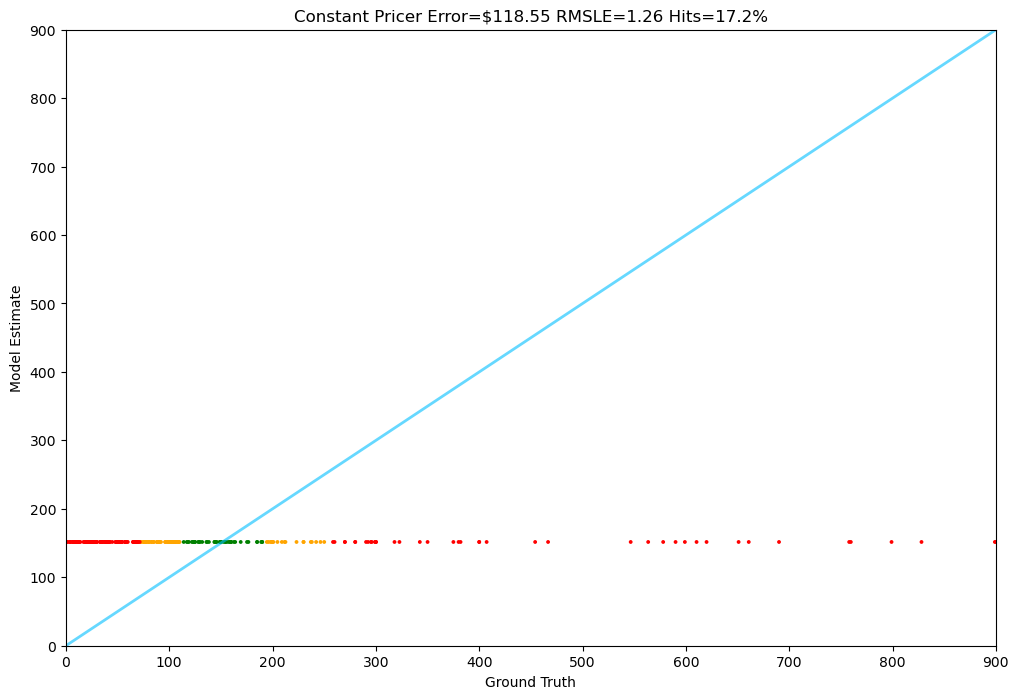

In [16]:
# Run our constant predictor
Tester.test(constant_pricer)


In [18]:
# Create a new "features" field on items, and populate it with json parsed from the details dict

for item in train:
    item.features = json.loads(item.details)
for item in test:
    item.features = json.loads(item.details)

# Look at one

In [ ]:
# Now some code to pluck out the Item Weight


def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

In [22]:
weights = [get_weight(t) for t in train]
weights = [w for w in weights if w]

In [24]:
def get_weight_with_default(item):
    weight = get_weight(item)
    return weight or average_weight

In [25]:
def get_rank(item):
    rank_dict = item.features.get("Best Sellers Rank")
    if rank_dict:
        ranks = rank_dict.values()
        return sum(ranks)/len(ranks)
    return None

In [26]:
ranks = [get_rank(t) for t in train]
ranks = [r for r in ranks if r]
average_rank = sum(ranks)/len(ranks)
average_rank

254859.6680579486

In [27]:
def get_rank_with_default(item):
    rank = get_rank(item)
    return rank or average_rank

In [28]:
def get_text_length(item):
    return len(item.test_prompt())

In [29]:
# investigate the brands

brands = Counter()
for t in train:
    brand = t.features.get("Brand")
    if brand:
        brands[brand]+=1

# Look at most common 40 brands

brands.most_common(40)

[('Kohler', 605),
 ('Kingston Brass', 484),
 ('Moen', 470),
 ('DELTA FAUCET', 426),
 ('SAMSUNG', 372),
 ('DEWALT', 365),
 ('Funko', 344),
 ('Magic The Gathering', 328),
 ('Makita', 323),
 ('Kichler', 311),
 ('Filterbuy', 308),
 ('Milwaukee', 289),
 ('Progress Lighting', 273),
 ('American Standard', 239),
 ('Generic', 218),
 ('BOSCH', 210),
 ('Cosmas', 209),
 ('Livex Lighting', 203),
 ('Safavieh', 195),
 ('JONATHAN Y', 176),
 ('Hunter Fan Company', 174),
 ('Pfister', 167),
 ('GROHE', 155),
 ('Fender', 149),
 ('GE', 149),
 ('Pokemon', 147),
 ('Yu-Gi-Oh!', 141),
 ('3M', 138),
 ('Possini Euro Design', 124),
 ('KNIPEX', 123),
 ('Festool', 122),
 ('Rockville', 118),
 ('Nuvo', 117),
 ('Elkay', 116),
 ('MINKA-AIRE', 116),
 ('SCHLAGE', 113),
 ('Craftsman', 112),
 ('RIDGID', 111),
 ('Elk Home', 110),
 ('Leviton', 110)]

In [33]:
TOP_ELECTRONICS_BRANDS = ["bosch", "schlage", "leviton", "cosmas", "kichler", "samsung", "funko", "nuvo", "elkay"]
def is_top_electronics_brand(item):
    brand = item.features.get("Brand")
    return brand and brand.lower() in TOP_ELECTRONICS_BRANDS

In [34]:
def get_features(item):
    return {
        "weight": get_weight_with_default(item),
        "rank": get_rank_with_default(item),
        "text_length": get_text_length(item),
        "is_top_electronics_brand": 1 if is_top_electronics_brand(item) else 0
    }

In [36]:
# Look at features in a training item
get_features(train[4])

{'weight': 1.7416532919451844,
 'rank': 60805.5,
 'text_length': 872,
 'is_top_electronics_brand': 0}

In [37]:
# A utility function to convert our features into a pandas dataframe

def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])

In [38]:
# Traditional Linear Regression!

np.random.seed(42)

# Separate features and target
feature_columns = ['weight', 'rank', 'text_length', 'is_top_electronics_brand']

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

# Train a Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

# Predict the test set and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

weight: 2.567600016280896
rank: 4.8363883226291336e-05
text_length: 0.05606303493539767
is_top_electronics_brand: 39.35520740947696
Intercept: 74.58096663724254
Mean Squared Error: 24281.616959055133
R-squared Score: 0.18474164123994885


In [39]:
# Function to predict price for a new item

def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

1: Guess: $134.12 Truth: $195.99 Error: $61.87 SLE: 0.14 Item: Vertex Ultraphonix MKII Overdrive
2: Guess: $139.32 Truth: $38.99 Error: $100.33 SLE: 1.58 Item: Wood Grip | Universal Conversion Kit | B...
3: Guess: $118.00 Truth: $1.00 Error: $117.00 SLE: 16.69 Item: Traxxas 1726 Antenna, Tube, Vinyl Antenn...
4: Guess: $122.26 Truth: $299.99 Error: $177.73 SLE: 0.80 Item: Jackson JS Series Dinky Arch Top JS32Q D...
5: Guess: $344.40 Truth: $374.99 Error: $30.59 SLE: 0.01 Item: TOTO LPT754.8#01 Whitney Lavatory and Pe...
6: Guess: $145.15 Truth: $64.95 Error: $80.20 SLE: 0.63 Item: Sliding Glass Patio Door Handle Set, Mor...
7: Guess: $254.95 Truth: $279.99 Error: $25.04 SLE: 0.01 Item: First Watch / Homak 6-Gun Security Cabin...
8: Guess: $151.13 Truth: $131.85 Error: $19.28 SLE: 0.02 Item: WEN 3921 16-inch Two-Direction Variable ...
9: Guess: $194.53 Truth: $185.11 Error: $9.42 SLE: 0.00 Item: Tropwellhouse Crytal Ceiling Fan with Li...
10: Guess: $134.73 Truth: $72.69 Error: $62.04 S

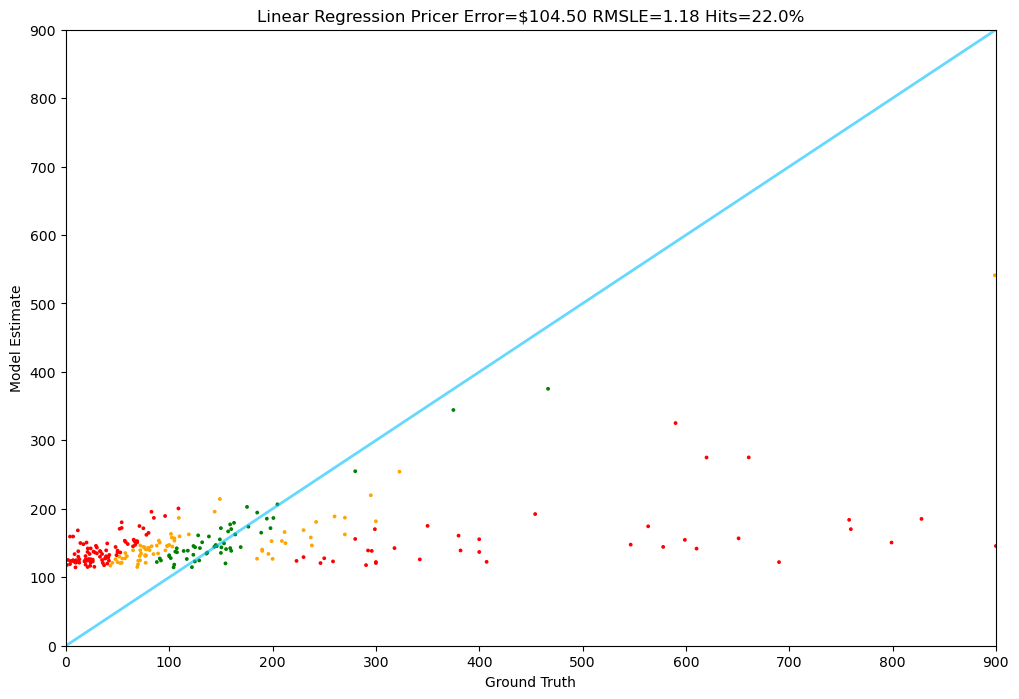

In [40]:
# test it

Tester.test(linear_regression_pricer)

In [41]:
# For the next few models, we prepare our documents and prices
# Note that we use the test prompt for the documents, otherwise we'll reveal the answer!!

prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

In [42]:
# Use the CountVectorizer for a Bag of Words model

np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

LinearRegression()

In [43]:
def bow_lr_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)

1: Guess: $204.27 Truth: $195.99 Error: $8.28 SLE: 0.00 Item: Vertex Ultraphonix MKII Overdrive
2: Guess: $25.09 Truth: $38.99 Error: $13.90 SLE: 0.18 Item: Wood Grip | Universal Conversion Kit | B...
3: Guess: $73.14 Truth: $1.00 Error: $72.14 SLE: 13.05 Item: Traxxas 1726 Antenna, Tube, Vinyl Antenn...
4: Guess: $410.82 Truth: $299.99 Error: $110.83 SLE: 0.10 Item: Jackson JS Series Dinky Arch Top JS32Q D...
5: Guess: $217.07 Truth: $374.99 Error: $157.92 SLE: 0.30 Item: TOTO LPT754.8#01 Whitney Lavatory and Pe...
6: Guess: $114.86 Truth: $64.95 Error: $49.91 SLE: 0.32 Item: Sliding Glass Patio Door Handle Set, Mor...
7: Guess: $160.01 Truth: $279.99 Error: $119.98 SLE: 0.31 Item: First Watch / Homak 6-Gun Security Cabin...
8: Guess: $204.17 Truth: $131.85 Error: $72.32 SLE: 0.19 Item: WEN 3921 16-inch Two-Direction Variable ...
9: Guess: $231.82 Truth: $185.11 Error: $46.71 SLE: 0.05 Item: Tropwellhouse Crytal Ceiling Fan with Li...
10: Guess: $82.56 Truth: $72.69 Error: $9.87 SLE: 

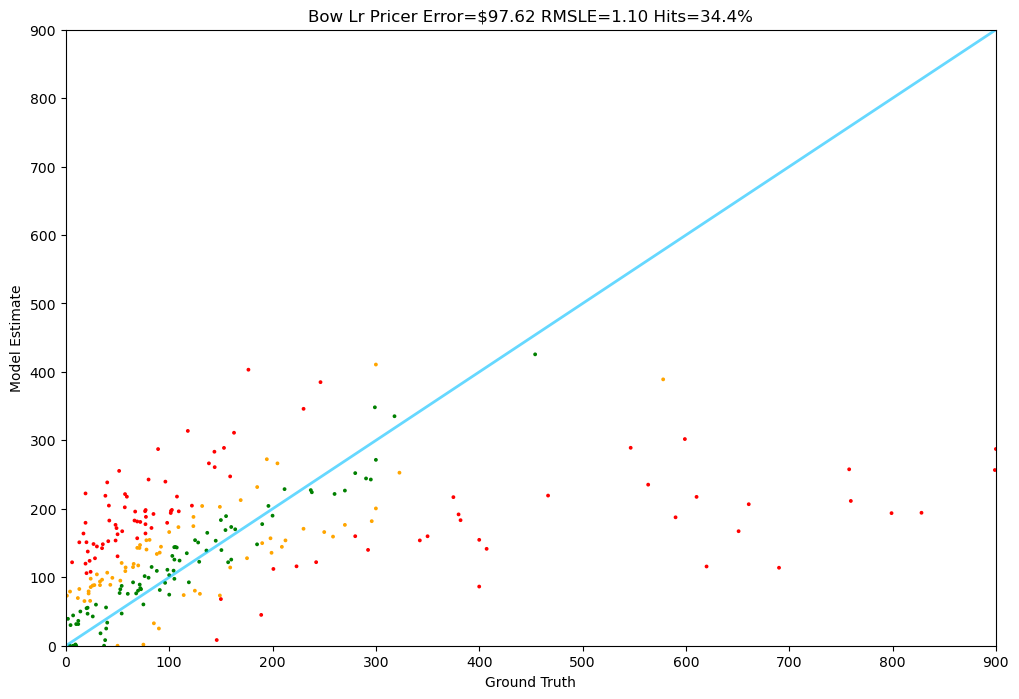

In [44]:
# test it

Tester.test(bow_lr_pricer)

In [45]:
# The amazing word2vec model, implemented in gensim NLP library

np.random.seed(42)

# Preprocess the documents
processed_docs = [simple_preprocess(doc) for doc in documents]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)

In [46]:
# This step of averaging vectors across the document is a weakness in our approach

def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

# Create feature matrix
X_w2v = np.array([document_vector(doc) for doc in documents])

In [47]:
# Run Linear Regression on word2vec

word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

LinearRegression()

In [48]:
def word2vec_lr_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])

1: Guess: $294.60 Truth: $195.99 Error: $98.61 SLE: 0.16 Item: Vertex Ultraphonix MKII Overdrive
2: Guess: $182.21 Truth: $38.99 Error: $143.22 SLE: 2.32 Item: Wood Grip | Universal Conversion Kit | B...
3: Guess: $72.86 Truth: $1.00 Error: $71.86 SLE: 13.03 Item: Traxxas 1726 Antenna, Tube, Vinyl Antenn...
4: Guess: $393.15 Truth: $299.99 Error: $93.16 SLE: 0.07 Item: Jackson JS Series Dinky Arch Top JS32Q D...
5: Guess: $277.81 Truth: $374.99 Error: $97.18 SLE: 0.09 Item: TOTO LPT754.8#01 Whitney Lavatory and Pe...
6: Guess: $161.29 Truth: $64.95 Error: $96.34 SLE: 0.81 Item: Sliding Glass Patio Door Handle Set, Mor...
7: Guess: $221.37 Truth: $279.99 Error: $58.62 SLE: 0.05 Item: First Watch / Homak 6-Gun Security Cabin...
8: Guess: $245.15 Truth: $131.85 Error: $113.30 SLE: 0.38 Item: WEN 3921 16-inch Two-Direction Variable ...
9: Guess: $235.55 Truth: $185.11 Error: $50.44 SLE: 0.06 Item: Tropwellhouse Crytal Ceiling Fan with Li...
10: Guess: $84.66 Truth: $72.69 Error: $11.97 SLE

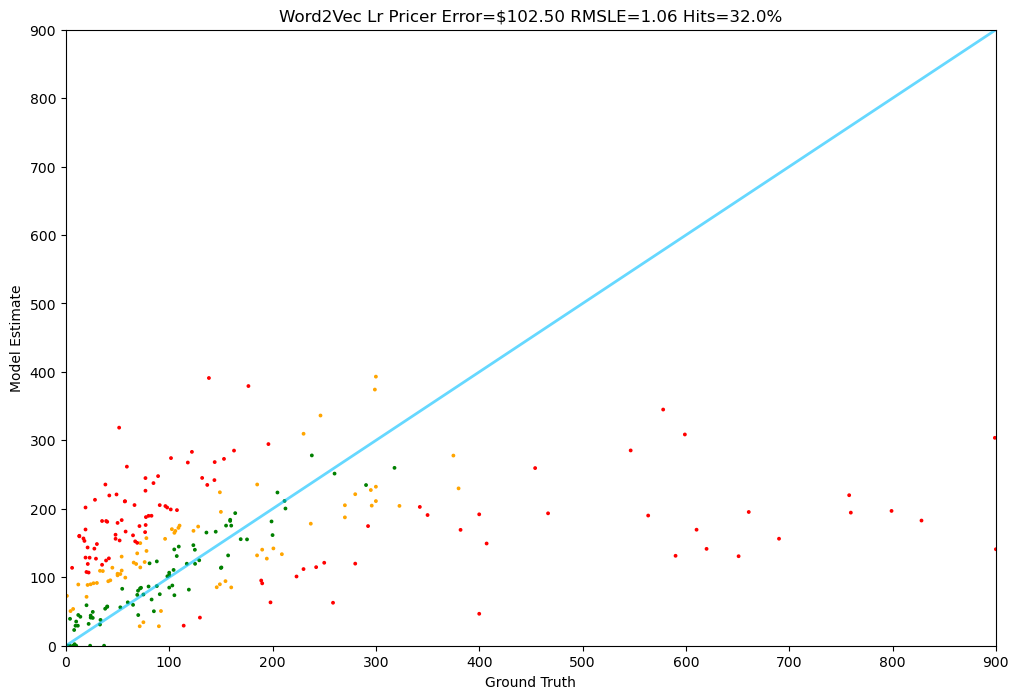

In [49]:
Tester.test(word2vec_lr_pricer)

In [50]:
# Support Vector Machines

np.random.seed(42)
svr_regressor = LinearSVR()

svr_regressor.fit(X_w2v, prices)

LinearSVR()

In [51]:
def svr_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)

1: Guess: $190.63 Truth: $195.99 Error: $5.36 SLE: 0.00 Item: Vertex Ultraphonix MKII Overdrive
2: Guess: $119.22 Truth: $38.99 Error: $80.23 SLE: 1.21 Item: Wood Grip | Universal Conversion Kit | B...
3: Guess: $46.69 Truth: $1.00 Error: $45.69 SLE: 10.06 Item: Traxxas 1726 Antenna, Tube, Vinyl Antenn...
4: Guess: $251.25 Truth: $299.99 Error: $48.74 SLE: 0.03 Item: Jackson JS Series Dinky Arch Top JS32Q D...
5: Guess: $183.37 Truth: $374.99 Error: $191.62 SLE: 0.51 Item: TOTO LPT754.8#01 Whitney Lavatory and Pe...
6: Guess: $94.36 Truth: $64.95 Error: $29.41 SLE: 0.14 Item: Sliding Glass Patio Door Handle Set, Mor...
7: Guess: $142.57 Truth: $279.99 Error: $137.42 SLE: 0.45 Item: First Watch / Homak 6-Gun Security Cabin...
8: Guess: $172.50 Truth: $131.85 Error: $40.65 SLE: 0.07 Item: WEN 3921 16-inch Two-Direction Variable ...
9: Guess: $201.24 Truth: $185.11 Error: $16.13 SLE: 0.01 Item: Tropwellhouse Crytal Ceiling Fan with Li...
10: Guess: $95.55 Truth: $72.69 Error: $22.86 SLE: 

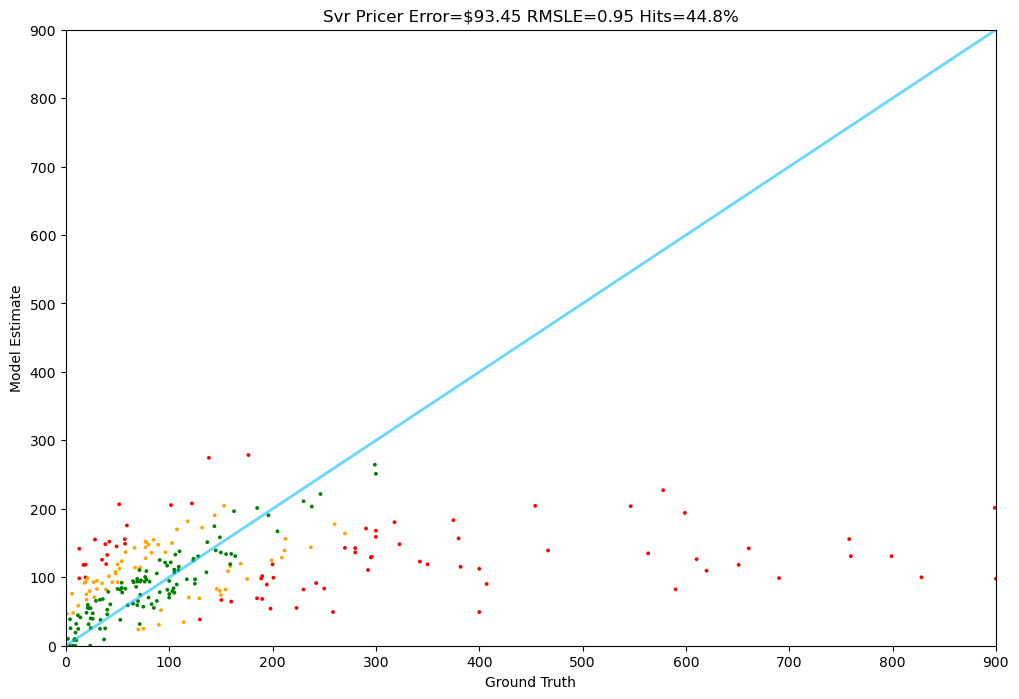

In [52]:
Tester.test(svr_pricer)

In [56]:
# And the powerful Random Forest regression

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=4)
rf_model.fit(X_w2v, prices)

RandomForestRegressor(n_jobs=4, random_state=42)

In [54]:
def random_forest_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, rf_model.predict([doc_vector])[0])

In [55]:
Tester.test(random_forest_pricer)

IndexError: list index out of range